#**Data Manipulation**
---



In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")
print(train.shape)
train.head()

(595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

**There aren't any null values in the dataset. There aren't any categorical/text data that needs to be changed either.**

0    573518
1     21694
Name: target, dtype: int64


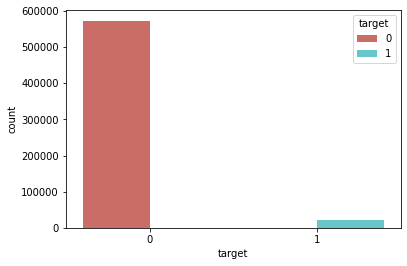

In [6]:
print(train['target'].value_counts())
sns.countplot(x='target', hue='target' ,data=train, palette="hls")
plt.show()

**The data is imbalanced.**


In [7]:
bin_col = []
cat_col = []
num_col = []

for i in train.columns:
    if train[i].nunique() == 2:
        bin_col.append(i)
    elif train[i].nunique() == 3:
        cat_col.append(i)
    else:
        num_col.append(i)

print(bin_col)
print('Number of Binary variables:',len(bin_col))
print('*'*100)
print(cat_col)
print('Number of numeric variables:',len(cat_col))
print('*'*100)
print(num_col)
print('Number of numeric variables:',len(num_col))

['target', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_car_02_cat', 'ps_car_08_cat', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
Number of Binary variables: 20
****************************************************************************************************
['ps_ind_04_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_10_cat']
Number of numeric variables: 5
****************************************************************************************************
['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_05_cat', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_09_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 

**The above were the column names of the variables. Now to extract interval and ordinal variables from said columns.**

In [8]:
interval_col = []
nominal_col = []

for j in train.columns:
    if train[j].dtypes == float:
        interval_col.append(j)
    elif "cat" in j or j == "id":
        nominal_col.append(j)
        
print(interval_col)
print("Number of interval variables:",len(interval_col))
print("*"*100)
print(nominal_col)
print("Number of Ordinal variables:",len(nominal_col))

['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']
Number of interval variables: 10
****************************************************************************************************
['id', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
Number of Ordinal variables: 15


In [9]:
train[interval_col].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [10]:
train[nominal_col].describe()

,id,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,1.358943,0.416794,0.405188,8.295933,0.829948,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674
std,4.293678e+05,0.664594,0.493311,1.350642,2.508270,0.375679,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455
min,7.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000
25%,3.719915e+05,1.000000,0.000000,0.000000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000
50%,7.435475e+05,1.000000,0.000000,0.000000,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000
75%,1.115549e+06,2.000000,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.000000,1.000000,2.000000,1.000000,93.000000
max,1.488027e+06,4.000000,1.000000,6.000000,11.000000,1.000000,1.000000,9.000000,1.000000,17.000000,1.000000,1.000000,4.000000,2.000000,104.000000


In [11]:
train[bin_col].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_car_02_cat,ps_car_08_cat,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.829948,0.832080,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.375679,0.373796,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Given the abundance of zeros in the Pandas desriptions as well as the mean of the training data being 0.36448, it is evident that the data is imbalaced.**

# **Visualizing the Dataset**
---

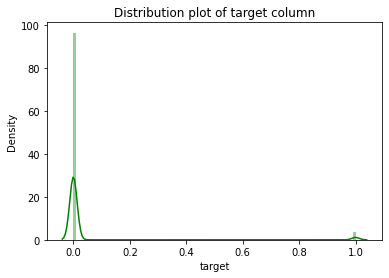

In [12]:
sns.distplot(train['target'], color='g', bins=100);
plt.title("Distribution plot of target column")
plt.show()

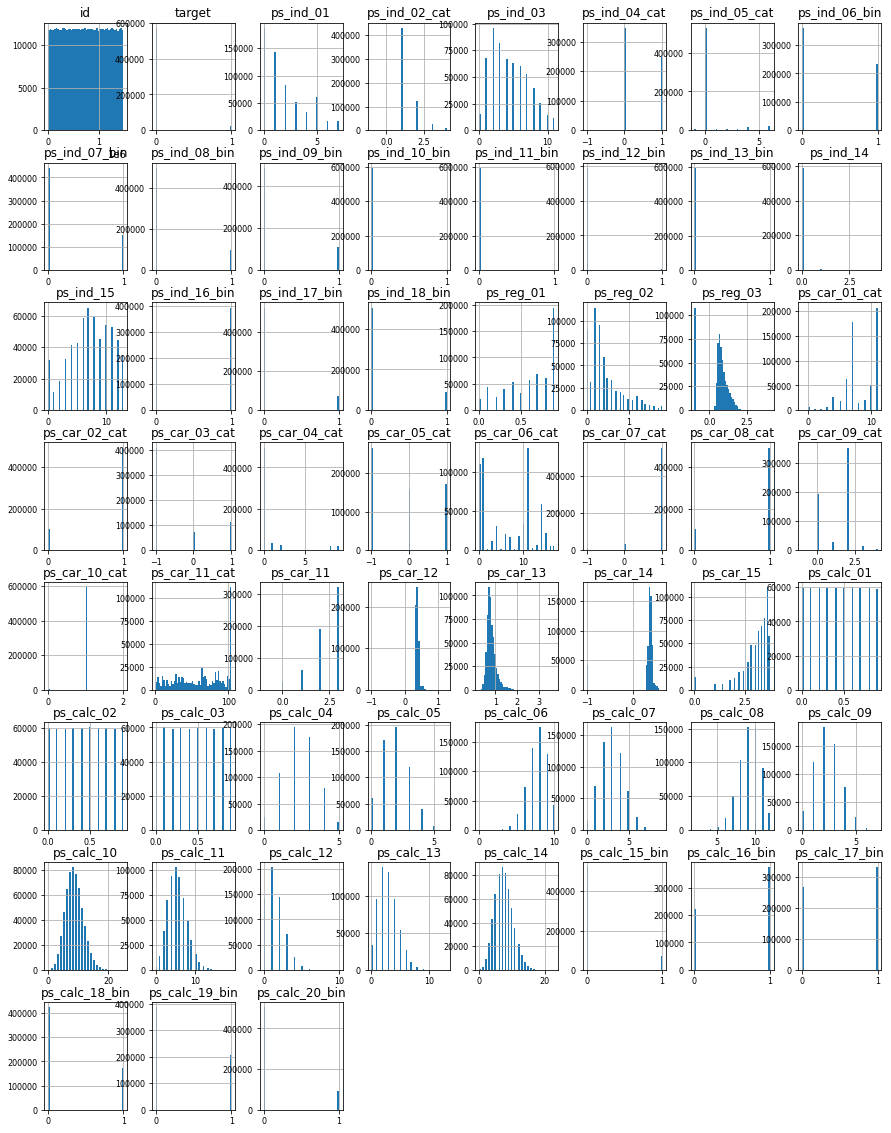

In [13]:
train.hist(figsize=(15,20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

**Data isn't equally inclined with target variables, hence they need to be aligned using multiple techniques**

# **Correlation amongst features**
---

In [14]:
train.corr()['target'].sort_values(ascending=False)

target            1.000000
ps_car_13         0.053899
ps_car_12         0.038790
ps_ind_17_bin     0.037053
ps_reg_02         0.034800
ps_ind_07_bin     0.034218
ps_car_04_cat     0.032900
ps_car_03_cat     0.032401
ps_reg_03         0.030888
ps_ind_05_cat     0.029165
ps_car_15         0.027667
ps_reg_01         0.022888
ps_car_05_cat     0.020754
ps_ind_01         0.018570
ps_car_01_cat     0.016256
ps_ind_08_bin     0.013147
ps_car_06_cat     0.011537
ps_ind_04_cat     0.009360
ps_ind_03         0.008360
ps_ind_12_bin     0.007810
ps_ind_14         0.007443
ps_car_11_cat     0.006129
ps_car_09_cat     0.005322
ps_ind_18_bin     0.004555
ps_ind_02_cat     0.004534
ps_ind_13_bin     0.002460
ps_ind_11_bin     0.002028
ps_calc_03        0.001907
ps_ind_10_bin     0.001815
ps_calc_01        0.001782
ps_calc_14        0.001362
ps_calc_02        0.001360
ps_calc_10        0.001061
ps_car_10_cat     0.001038
ps_calc_05        0.000771
ps_calc_09        0.000719
ps_calc_16_bin    0.000624
p

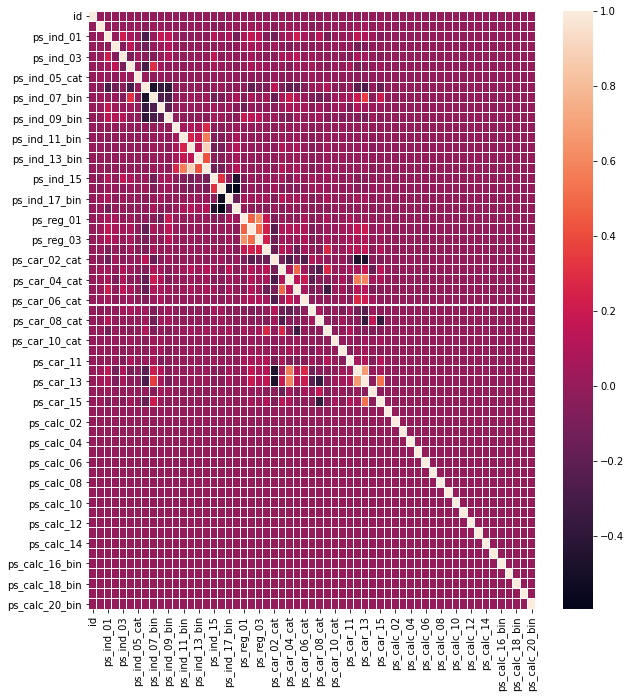

In [15]:
plt.figure(figsize=(10,11))
sns.heatmap(train.corr(),linewidths=0.01)
plt.show()

**This is a correlation matrix wrt target variables. Since the lightly coloured blocks represent higher correlation to the target column, and is of no use, it shall be removed.**



# **Exploratory Data Analysis (EDA)**
---
**Checking unique values amongst Categorical values**





In [16]:
for f in nominal_col:
    dist_values = train[f].nunique()
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable id has 595212 distinct values
Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_03_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_05_cat has 3 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


**Categorical values visualized as bar graphs**

<Figure size 432x288 with 0 Axes>

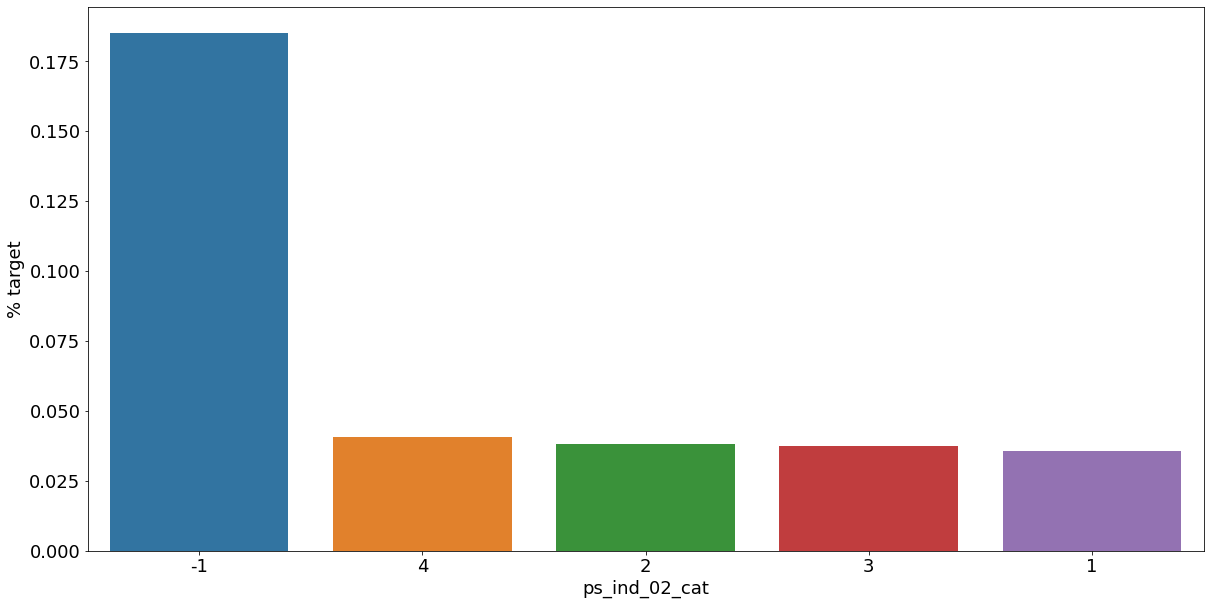

<Figure size 432x288 with 0 Axes>

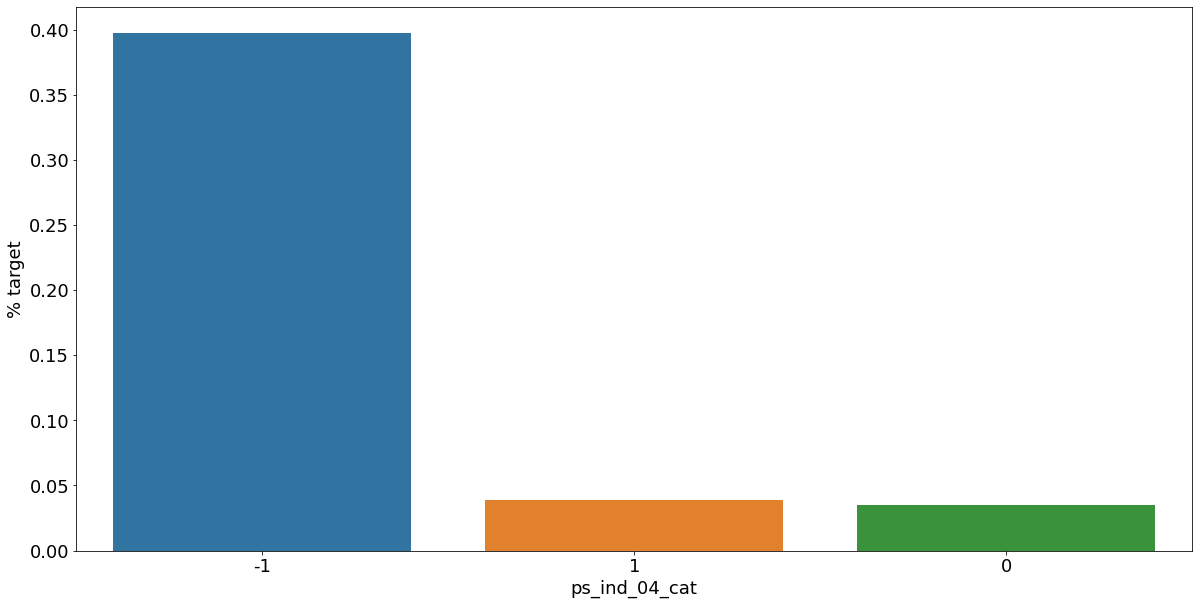

<Figure size 432x288 with 0 Axes>

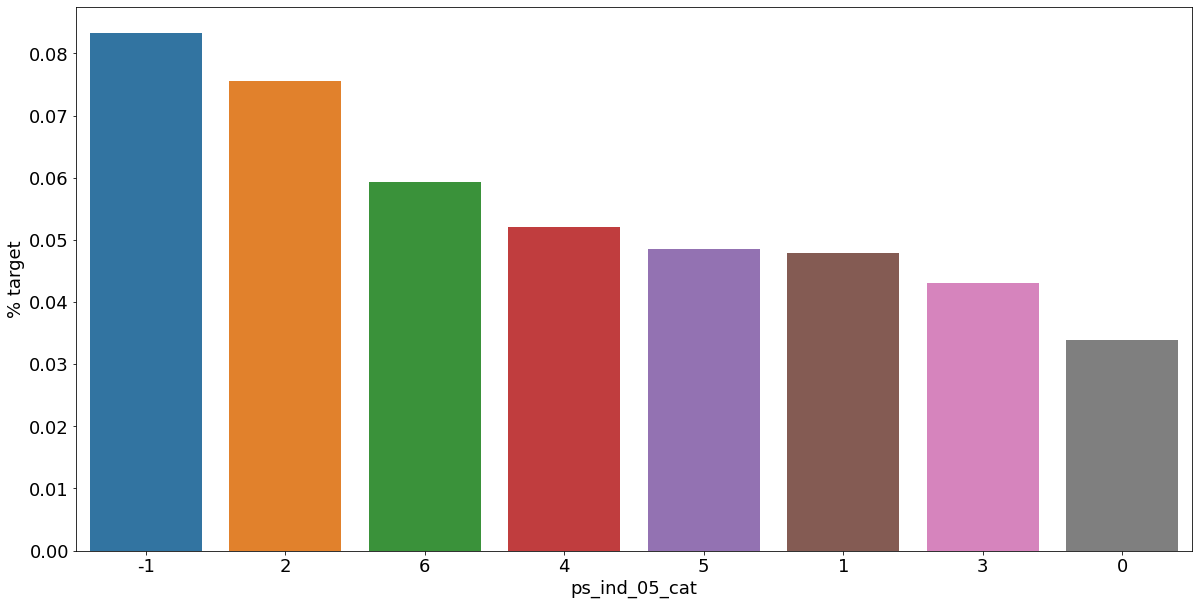

<Figure size 432x288 with 0 Axes>

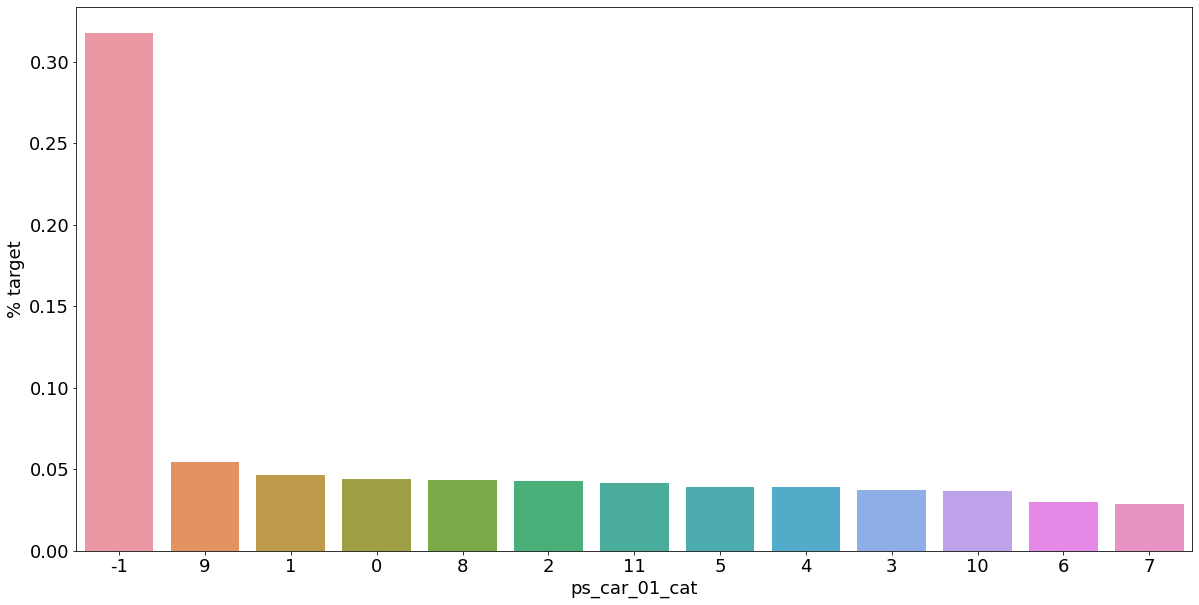

<Figure size 432x288 with 0 Axes>

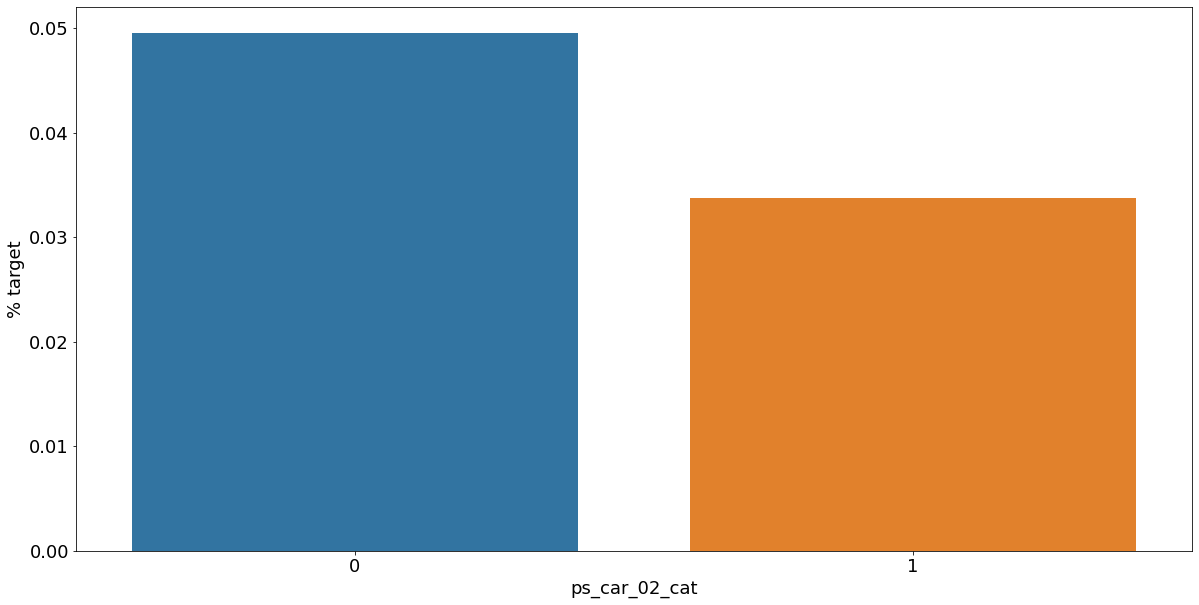

<Figure size 432x288 with 0 Axes>

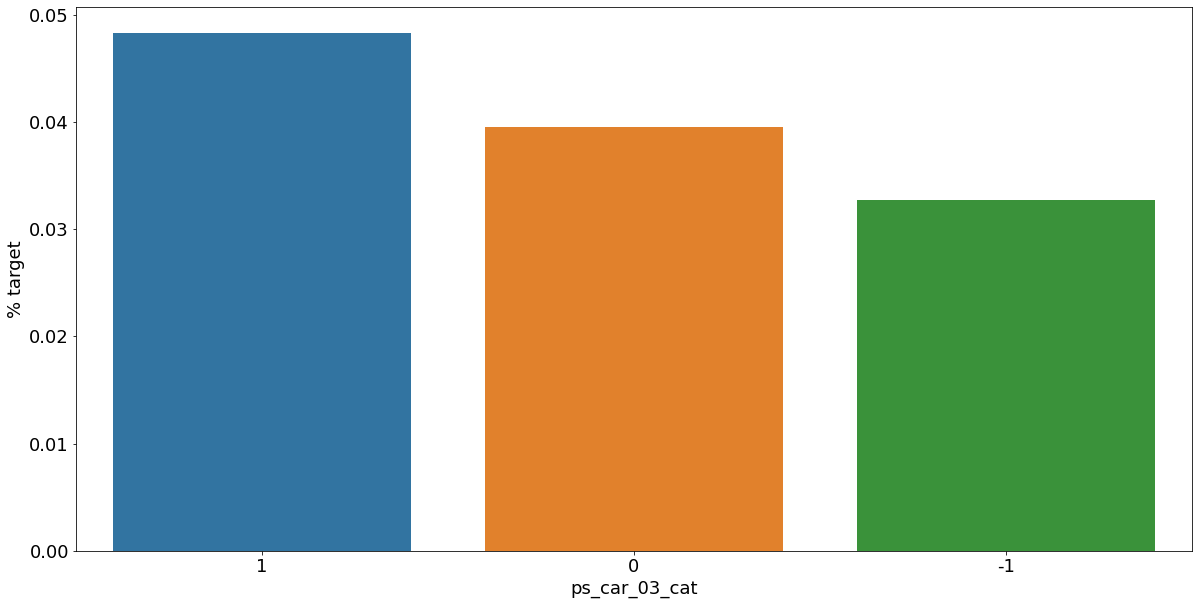

<Figure size 432x288 with 0 Axes>

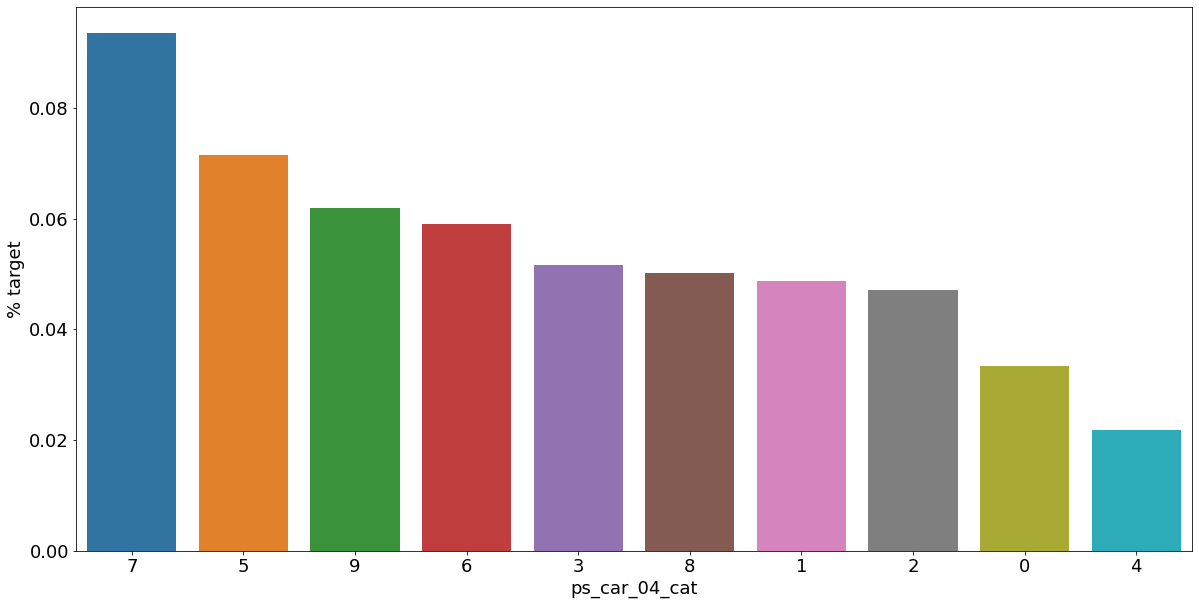

<Figure size 432x288 with 0 Axes>

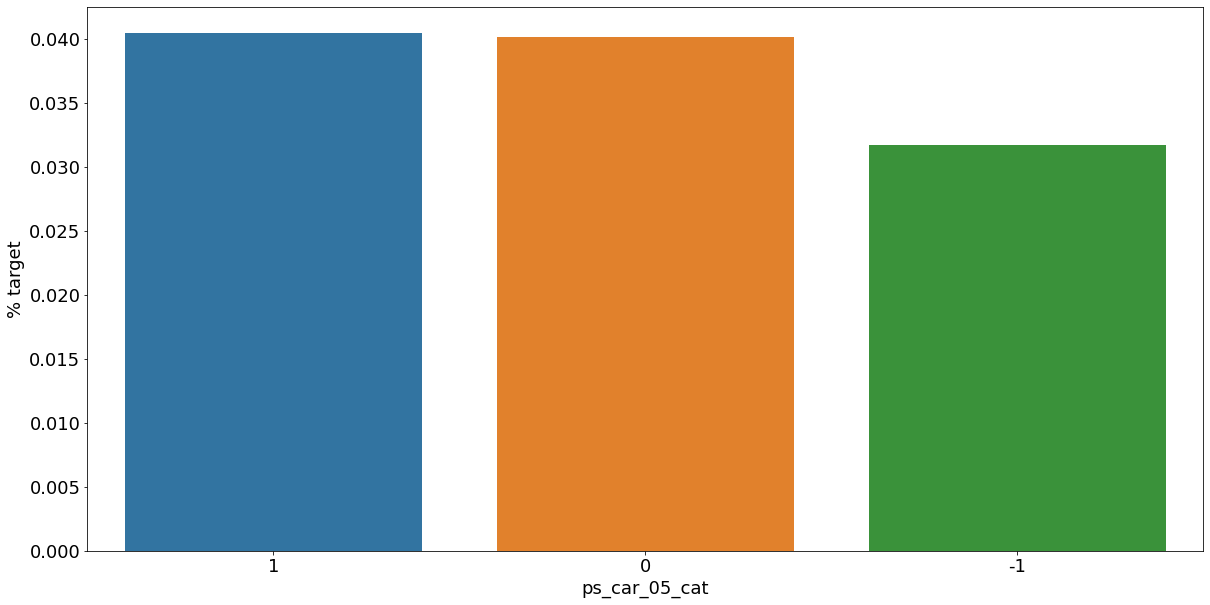

<Figure size 432x288 with 0 Axes>

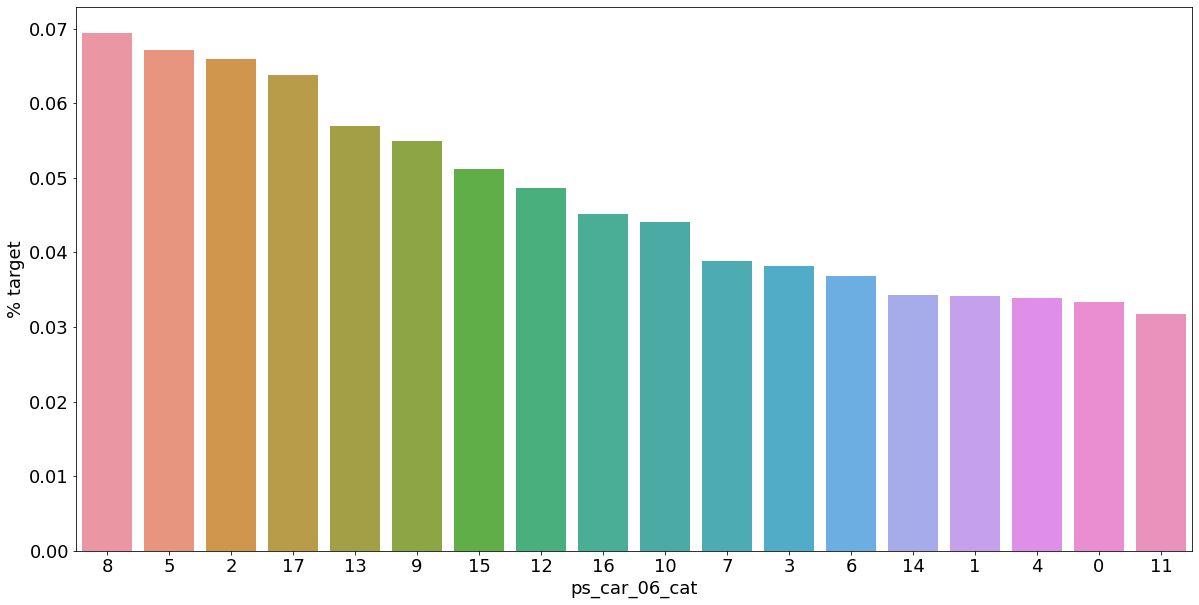

<Figure size 432x288 with 0 Axes>

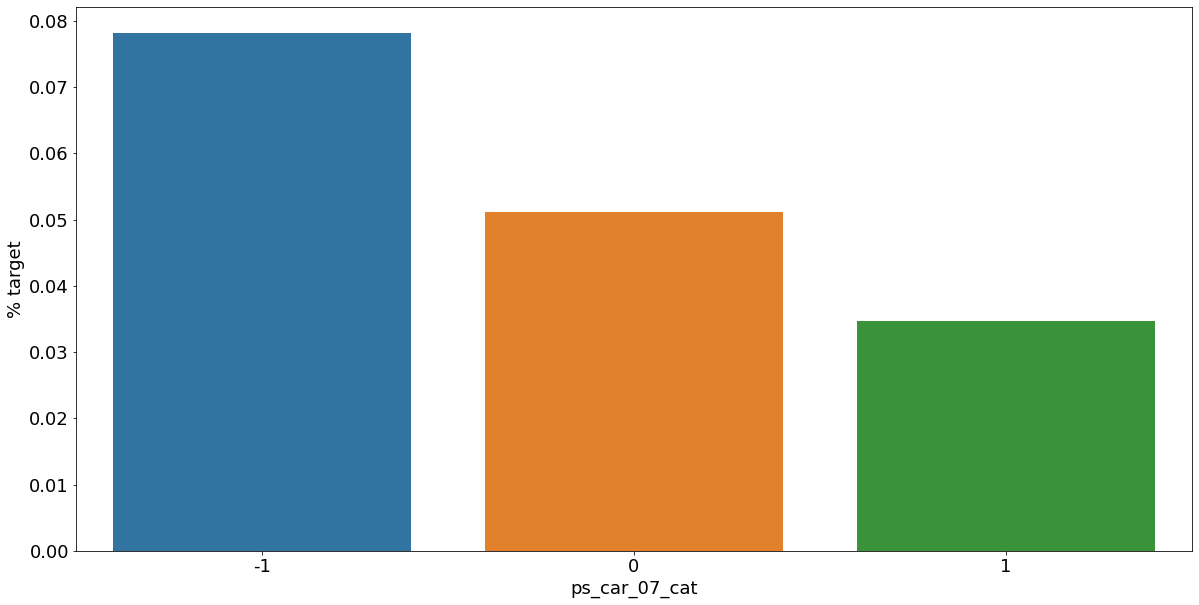

<Figure size 432x288 with 0 Axes>

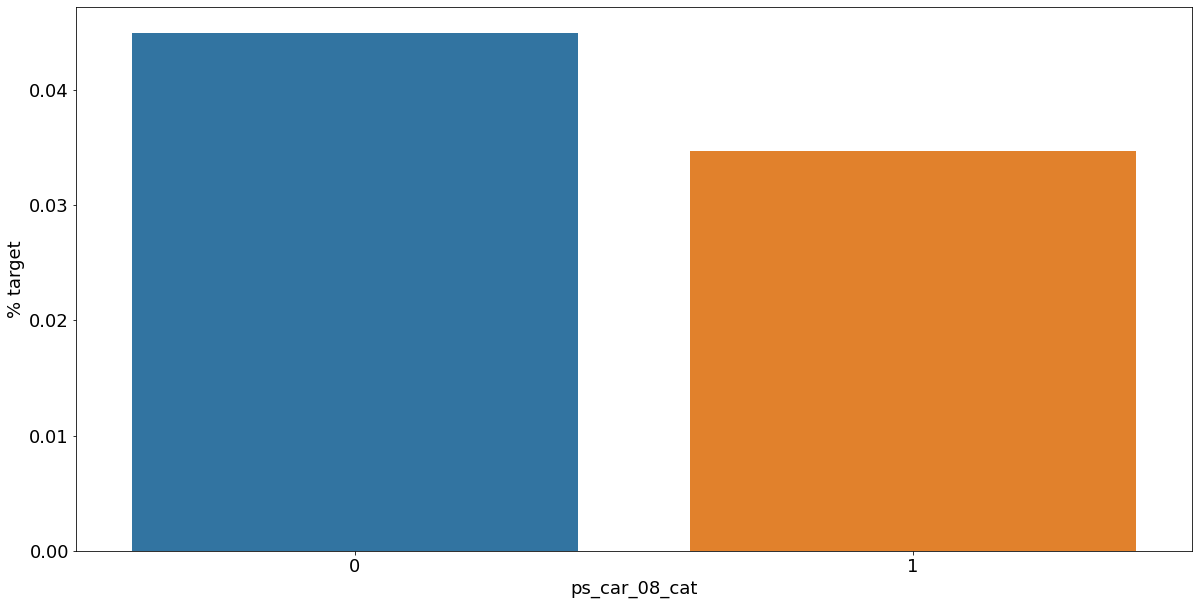

<Figure size 432x288 with 0 Axes>

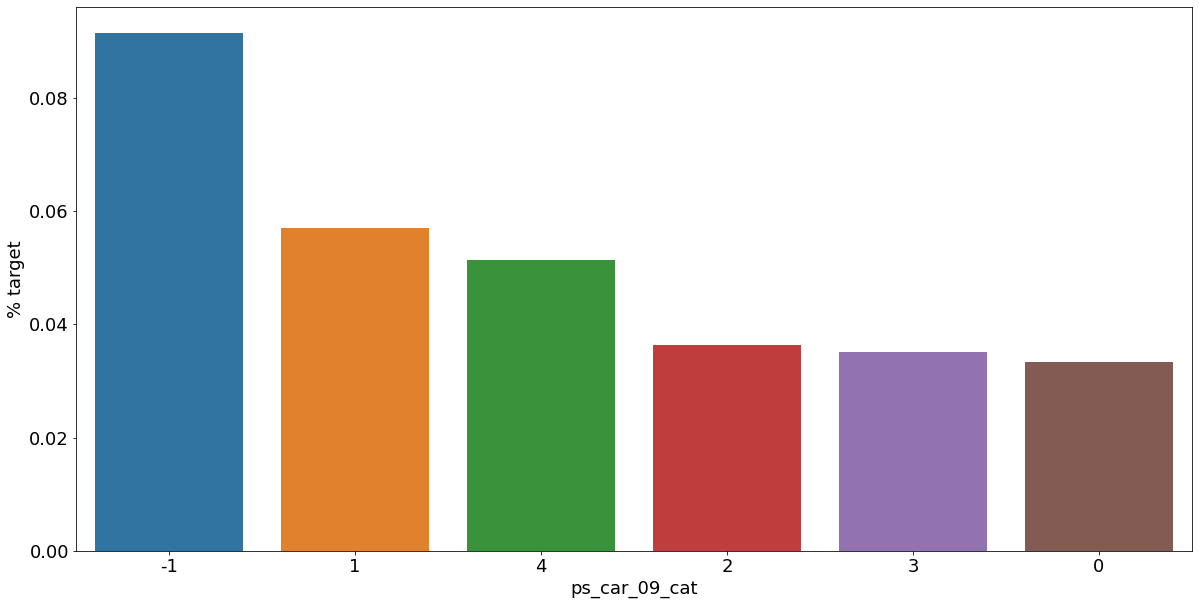

<Figure size 432x288 with 0 Axes>

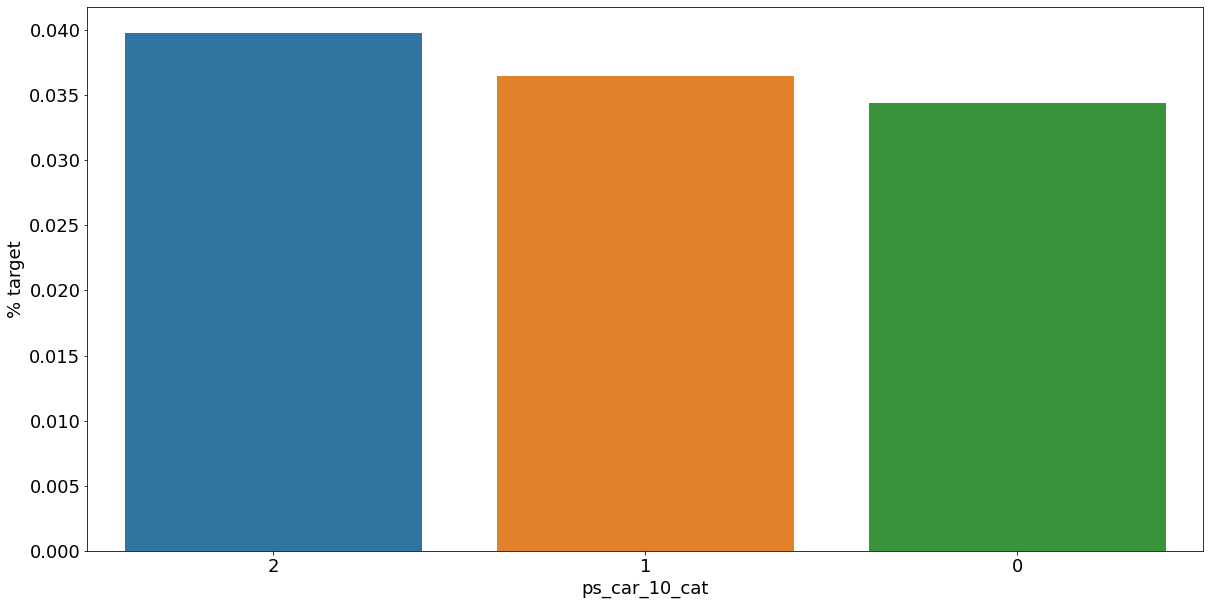

<Figure size 432x288 with 0 Axes>

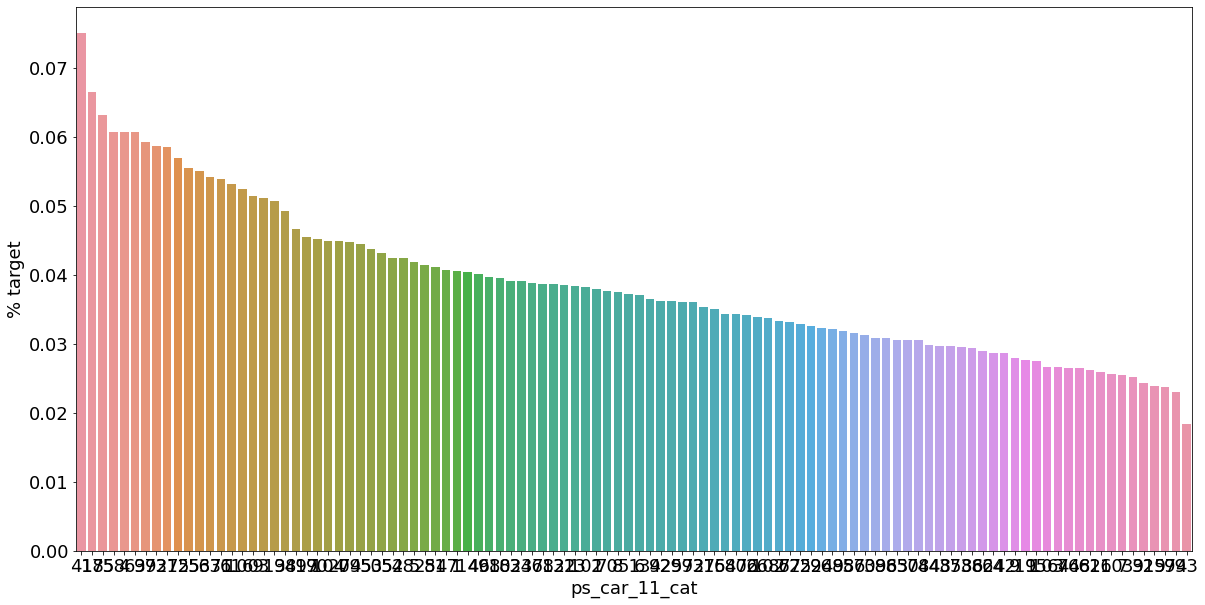

In [17]:
w = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_03_cat','ps_car_04_cat',\
     'ps_car_05_cat','ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat']
for f in w:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

Keep the missing values as a separate category value instead of replacing with mean/median/mode. Customers with missing value have extreme probabilities when it comes to claiming their insurance.

**Correlation between categorical values**

In [18]:
train[nominal_col+["target"]].corr()['target'].sort_values(ascending=False)

target           1.000000
ps_car_04_cat    0.032900
ps_car_03_cat    0.032401
ps_ind_05_cat    0.029165
ps_car_05_cat    0.020754
ps_car_01_cat    0.016256
ps_car_06_cat    0.011537
ps_ind_04_cat    0.009360
ps_car_11_cat    0.006129
ps_car_09_cat    0.005322
ps_ind_02_cat    0.004534
ps_car_10_cat    0.001038
id              -0.000188
ps_car_08_cat   -0.020342
ps_car_02_cat   -0.031545
ps_car_07_cat   -0.036395
Name: target, dtype: float64

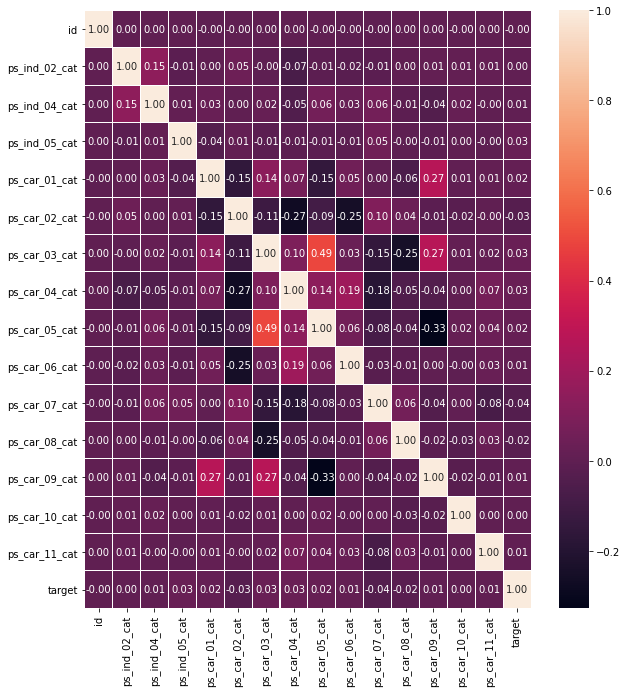

In [19]:
plt.figure(figsize=(10,11))
sns.heatmap(train[nominal_col+["target"]].corr(),annot=True,linewidths=0.01,fmt=".2f")
plt.show()

Most feautures are moderately correlated except for ps_car_03_cat and ps_car_05_cat, which have a higher correlation.

**EDA on Interval Features**

In [20]:
for f in interval_col:
    dist_values = train[f].nunique()
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_reg_01 has 10 distinct values
Variable ps_reg_02 has 19 distinct values
Variable ps_reg_03 has 5013 distinct values
Variable ps_car_12 has 184 distinct values
Variable ps_car_13 has 70482 distinct values
Variable ps_car_14 has 850 distinct values
Variable ps_car_15 has 15 distinct values
Variable ps_calc_01 has 10 distinct values
Variable ps_calc_02 has 10 distinct values
Variable ps_calc_03 has 10 distinct values


ps_car_13 and ps_reg_03 have the highest distinct values, ie: outliers.

In [21]:
train[interval_col+["target"]].corr()['target'].sort_values(ascending=False)

target        1.000000
ps_car_13     0.053899
ps_car_12     0.038790
ps_reg_02     0.034800
ps_reg_03     0.030888
ps_car_15     0.027667
ps_reg_01     0.022888
ps_calc_03    0.001907
ps_calc_01    0.001782
ps_calc_02    0.001360
ps_car_14    -0.004474
Name: target, dtype: float64

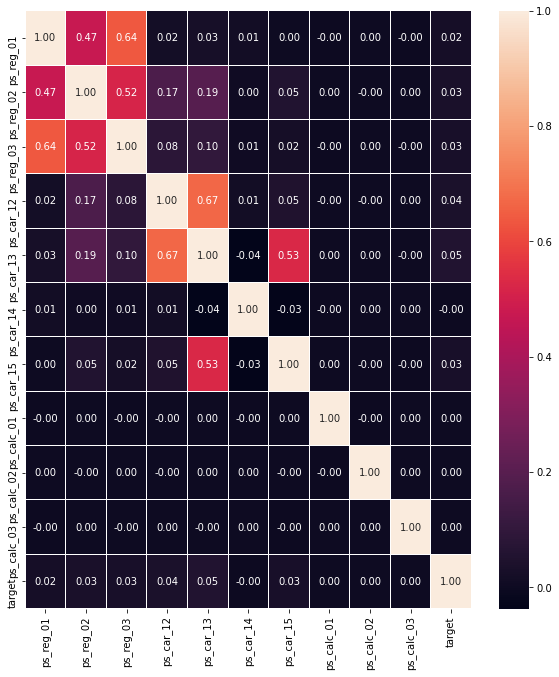

In [22]:
plt.figure(figsize=(10,11))
sns.heatmap(train[interval_col+["target"]].corr(),annot=True,linewidths=0.01,fmt=".2f")
plt.show()

Some variables like ps_reg_02 , ps_car_13 and ps_car_12 are highly correlated to the target variable which can be used to achieve accurate results.

**EDA on Binary Variables**

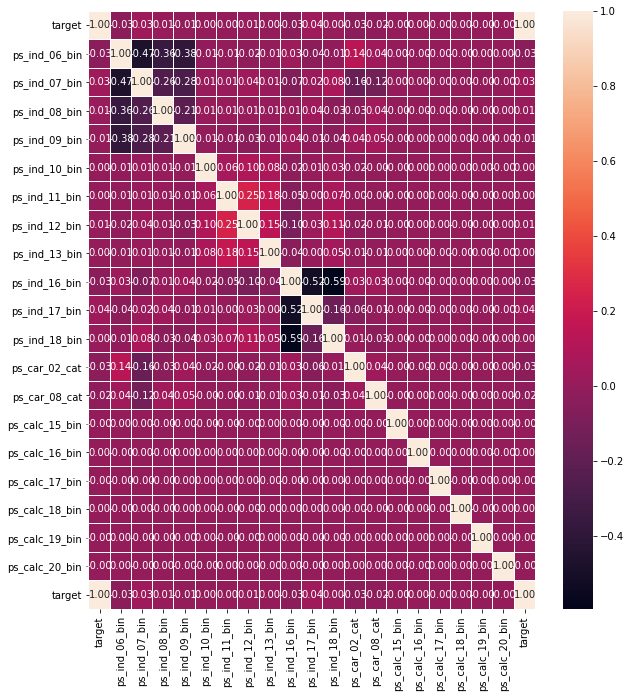

In [23]:
plt.figure(figsize=(10,11))
sns.heatmap(train[bin_col+["target"]].corr(),annot=True,linewidths=0.01,fmt=".2f")
plt.show()

*   **Highest corelation between ps_ind_11_bin and ps_ind_12_bin which is over 25%**
*   **None of the binary variables are highly co-related, neither are they equally balanced (this is useful for our model)**
*   **ps_reg_01 and ps_reg_02 are correlated with 47% and 70% from the plot above**

# **Machine Learning Models**
---
**ML model with imbalanced datasets**

In [24]:
y = train['target']
x = train.drop(['id','target'], axis =1)

In [25]:
x.shape, y.shape

((595212, 57), (595212,))

In [26]:
from collections import Counter

Counter(y)

Counter({0: 573518, 1: 21694})

In [27]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2,random_state=10)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((476169, 57), (119043, 57), (476169,), (119043,))

In [28]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train,y_train)

y_pred_trn = clf.predict(x_train)
y_pred_tst = clf.predict(x_test)

print("Train F1score:",f1_score(y_train, y_pred_trn))
print("Test F1score:",f1_score(y_test, y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(y_train, y_pred_trn))
print("Test precision_score:",precision_score(y_test, y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(y_train, y_pred_trn))
print("Test recall_score:",recall_score(y_test, y_pred_tst))

Train F1score: 0.0
Test F1score: 0.0


Train precision_score: 0.0
Test precision_score: 0.0


Train recall_score: 0.0
Test recall_score: 0.0


In [29]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


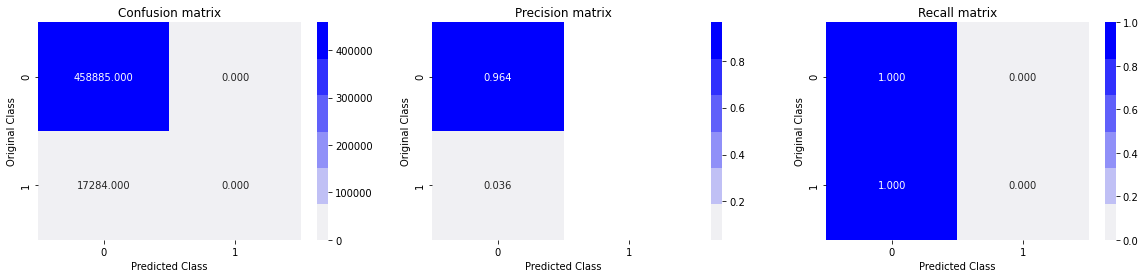

Test confusion_matrix


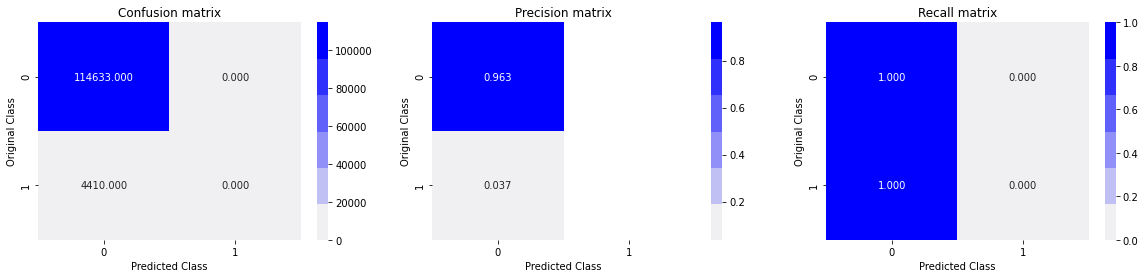

In [30]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,clf.predict(x_train))
print('Test confusion_matrix')
plot_confusion_matrix(y_test,clf.predict(x_test))

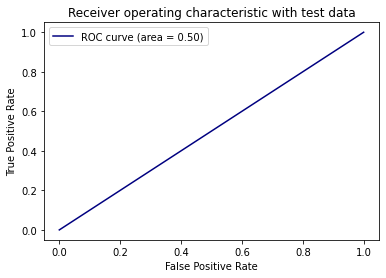

In [31]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,ths = roc_curve(y_test,clf.predict(x_test))
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

# **Notes:**


*   Shape of data before division is (595212, 53)
*   Training and testing sets are split 80:20
*   AUC val is 0.5, ie: model isn't the best for this situation
*   From the confusion matrix it can be inferred that the model is highly biased towards False Negatives. This is why F1 scores play a major role in this case.



---
*   **Since the target data isn't balanced, logistic regression does not do well and is biased towards 0. Target data balancing is very important in model training.**
*   **Both precision and recall are 0, as is F1 score, because target data is imbalanced which prevents logistic regression from being effective.**


In [32]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.svm import LinearSVC

clf = LinearSVC(dual = False, max_iter=1000)
clf.fit(x_train,y_train)

y_pred_trn = clf.predict(x_train)
y_pred_tst = clf.predict(x_test)

print("Train F1score:",f1_score(y_train, y_pred_trn))
print("Test F1score:",f1_score(y_test, y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(y_train, y_pred_trn))
print("Test precision_score:",precision_score(y_test, y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(y_train, y_pred_trn))
print("Test recall_score:",recall_score(y_test, y_pred_tst))

Train F1score: 0.0
Test F1score: 0.0


Train precision_score: 0.0
Test precision_score: 0.0


Train recall_score: 0.0
Test recall_score: 0.0


Train confusion_matrix


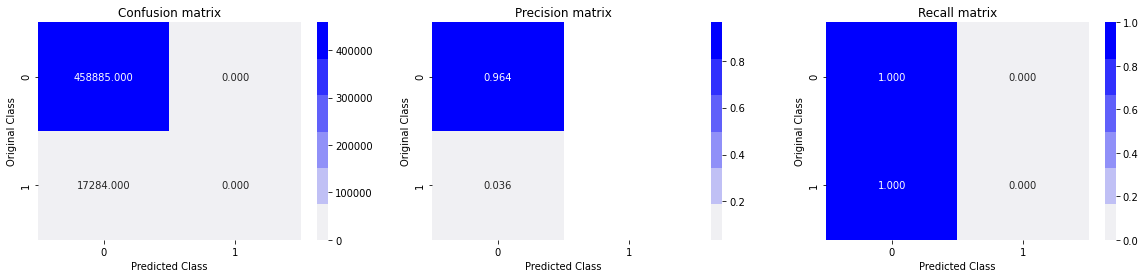

Test confusion_matrix


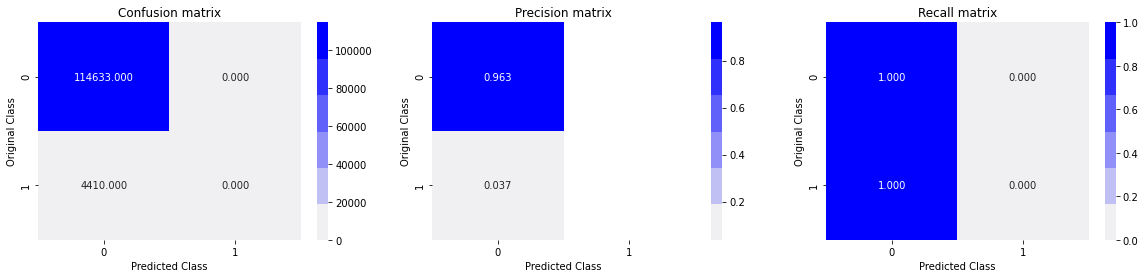

In [33]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,clf.predict(x_train))
print('Test confusion_matrix')
plot_confusion_matrix(y_test,clf.predict(x_test))

**Linear SVC wasn't too successful either as observed by the underfit in the confusion matrix**

# **Balancing with SMOTE**
---

In [34]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27)

X , Y = sm.fit_sample(x,y) 

X.shape,Y.shape

((1147036, 57), (1147036,))

In [35]:
from collections import Counter

Counter(Y)

Counter({0: 573518, 1: 573518})

In [36]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X, Y , test_size = 0.2, random_state = 10)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((917628, 57), (229408, 57), (917628,), (229408,))

In [37]:
from sklearn.preprocessing import StandardScaler

stand = StandardScaler()
stand.fit(X_train)

X_train = stand.transform(X_train)
X_test = stand.transform(X_test)

#**Simple Logistic Regression**
---

In [38]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train,Y_train)

Y_pred_trn = clf.predict(X_train)
Y_pred_tst = clf.predict(X_test)

print("Train accuracy score:",accuracy_score(Y_train, Y_pred_trn))
print("Test accuracy score:",accuracy_score(Y_test, Y_pred_tst))
print("\n")
print("Train F1score:",f1_score(Y_train, Y_pred_trn))
print("Test F1score:",f1_score(Y_test, Y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(Y_train, Y_pred_trn))
print("Test precision_score:",precision_score(Y_test, Y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(Y_train, Y_pred_trn))
print("Test recall_score:",recall_score(Y_test, Y_pred_tst))

Train accuracy score: 0.5874962403065295
Test accuracy score: 0.5884406821035012


Train F1score: 0.5790260964339138
Test F1score: 0.5806815506988271


Train precision_score: 0.5907381730959065
Test precision_score: 0.5935482699448889


Train recall_score: 0.5677694025683976
Test recall_score: 0.5683608353184608


Train confusion_matrix


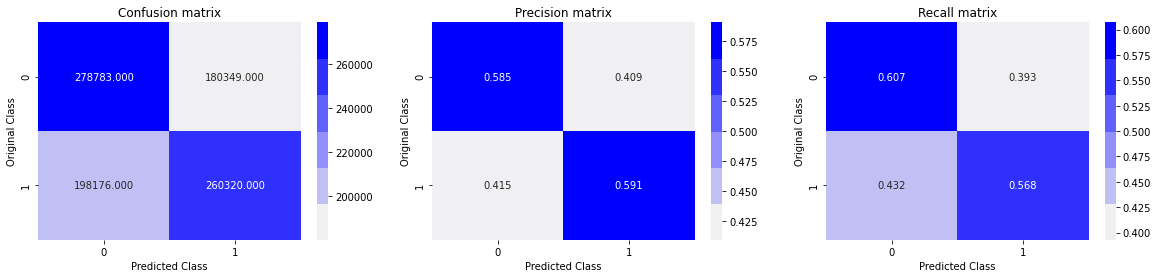

Test confusion_matrix


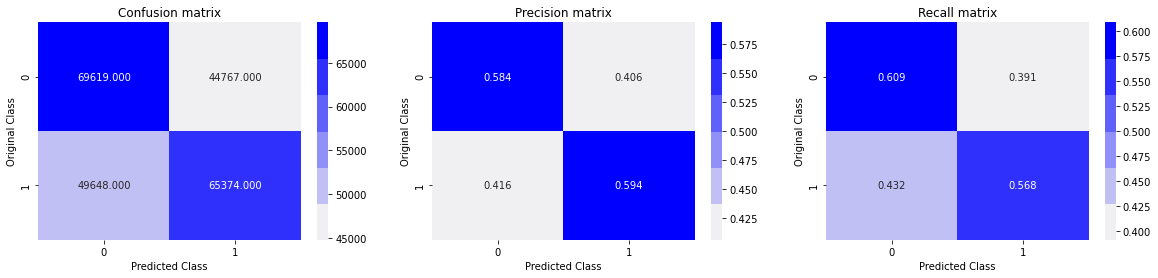

In [39]:
print('Train confusion_matrix')
plot_confusion_matrix(Y_train,clf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(Y_test,clf.predict(X_test))

#**Logistic Regression with lgfgs solver**
---

In [40]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train,Y_train)

Y_pred_trn = clf.predict(X_train)
Y_pred_tst = clf.predict(X_test)

print("Train accuracy score:",accuracy_score(Y_train, Y_pred_trn))
print("Test accuracy score:",accuracy_score(Y_test, Y_pred_tst))
print("\n")
print("Train F1score:",f1_score(Y_train, Y_pred_trn))
print("Test F1score:",f1_score(Y_test, Y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(Y_train, Y_pred_trn))
print("Test precision_score:",precision_score(Y_test, Y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(Y_train, Y_pred_trn))
print("Test recall_score:",recall_score(Y_test, Y_pred_tst))

Train accuracy score: 0.5874962403065295
Test accuracy score: 0.5884406821035012


Train F1score: 0.5790260964339138
Test F1score: 0.5806815506988271


Train precision_score: 0.5907381730959065
Test precision_score: 0.5935482699448889


Train recall_score: 0.5677694025683976
Test recall_score: 0.5683608353184608


Train confusion_matrix


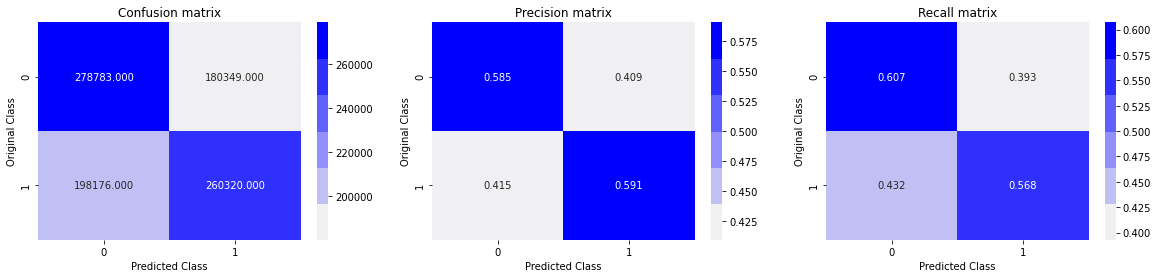

Test confusion_matrix


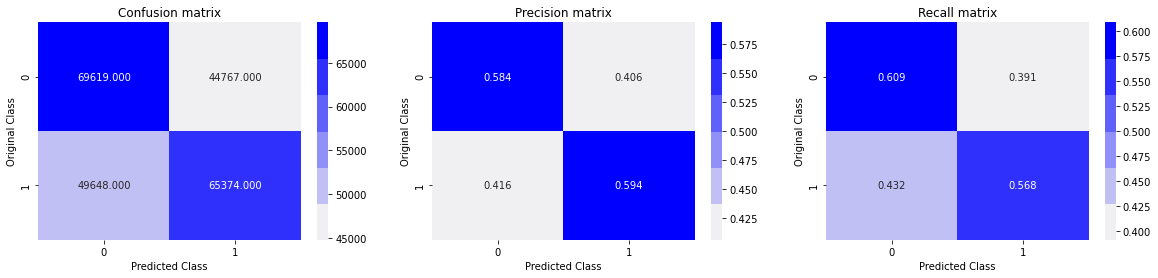

In [41]:
print('Train confusion_matrix')
plot_confusion_matrix(Y_train,clf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(Y_test,clf.predict(X_test))

#**Logistic Regression with liblinear solver (L2 penalty)**
---

In [42]:
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train,Y_train)

Y_pred_trn = clf.predict(X_train)
Y_pred_tst = clf.predict(X_test)

print("Train accuracy score:",accuracy_score(Y_train, Y_pred_trn))
print("Test accuracy score:",accuracy_score(Y_test, Y_pred_tst))
print("\n")
print("Train F1score:",f1_score(Y_train, Y_pred_trn))
print("Test F1score:",f1_score(Y_test, Y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(Y_train, Y_pred_trn))
print("Test precision_score:",precision_score(Y_test, Y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(Y_train, Y_pred_trn))
print("Test recall_score:",recall_score(Y_test, Y_pred_tst))

Train accuracy score: 0.5874875221767426
Test accuracy score: 0.588418886874041


Train F1score: 0.579020944801501
Test F1score: 0.5806574821683943


Train precision_score: 0.5907274489024842
Test precision_score: 0.5935264209188306


Train recall_score: 0.5677694025683976
Test recall_score: 0.5683347533515327


Train confusion_matrix


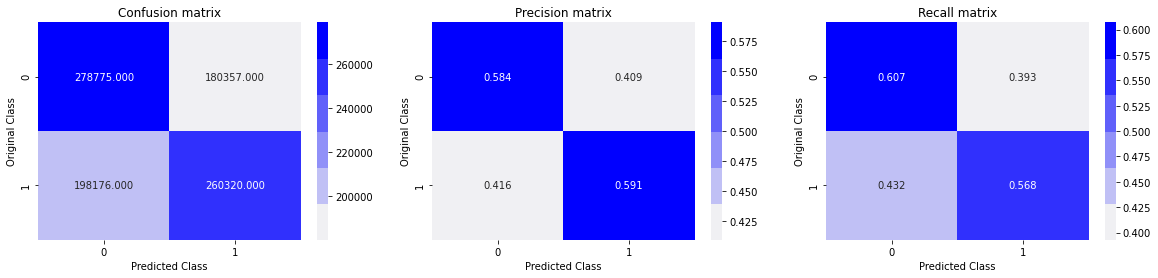

Test confusion_matrix


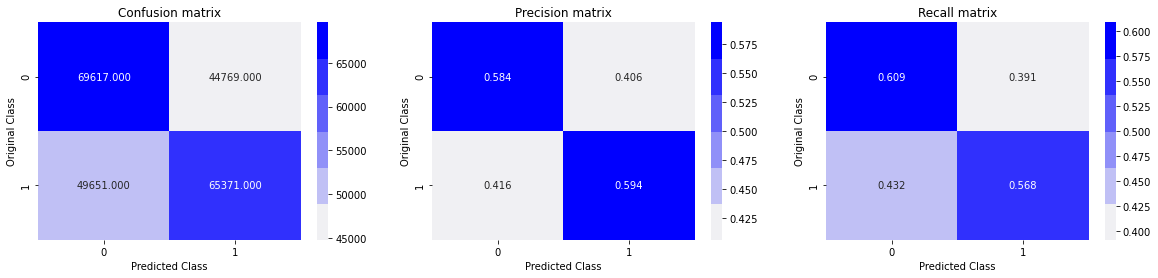

In [43]:
print('Train confusion_matrix')
plot_confusion_matrix(Y_train,clf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(Y_test,clf.predict(X_test))

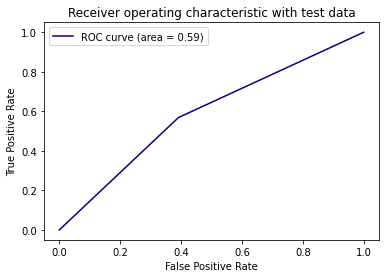

In [44]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,ths = roc_curve(Y_test,clf.predict(X_test))
auc_sc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

*   **AUC of 0.59... an improvement from log reg**
*   **LinearSVC with same features produced similar results to Log Reg... F1 score of 57.3%**
*   **Limiting the features results in the model becoming conservative and beginning to underfit which eventually leads to a decrease in the performance of the model over time**

#**Random Forest Classifier**
---

In [45]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
clf.fit(X_train,Y_train)

Y_pred_trn = clf.predict(X_train)
Y_pred_tst = clf.predict(X_test)

print("Train accuracy score:",accuracy_score(Y_train, Y_pred_trn))
print("Test accuracy score:",accuracy_score(Y_test, Y_pred_tst))
print("\n")
print("Train F1score:",f1_score(Y_train, Y_pred_trn))
print("Test F1score:",f1_score(Y_test, Y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(Y_train, Y_pred_trn))
print("Test precision_score:",precision_score(Y_test, Y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(Y_train, Y_pred_trn))
print("Test recall_score:",recall_score(Y_test, Y_pred_tst))

Train accuracy score: 0.9297416818144172
Test accuracy score: 0.9293267889524341


Train F1score: 0.927397767800334
Test F1score: 0.9272519238103785


Train precision_score: 0.9586945032327762
Test precision_score: 0.958115037600957


Train recall_score: 0.8980798087660525
Test recall_score: 0.898315104936447


Train confusion_matrix


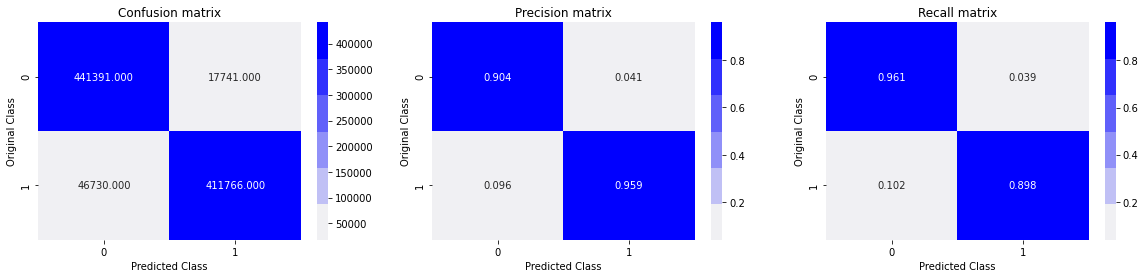

Test confusion_matrix


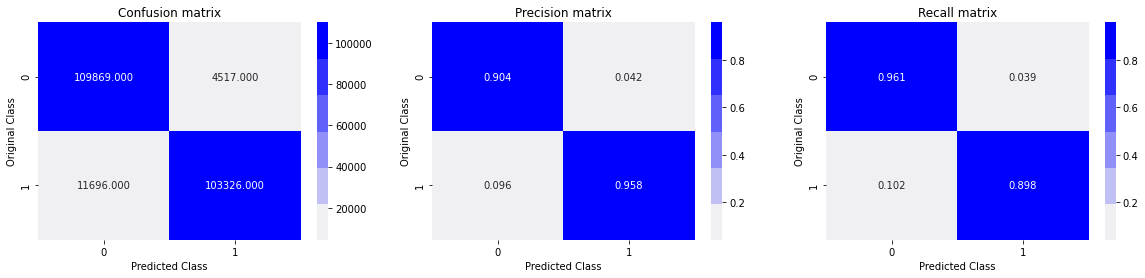

In [46]:
print('Train confusion_matrix')
plot_confusion_matrix(Y_train,clf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(Y_test,clf.predict(X_test))

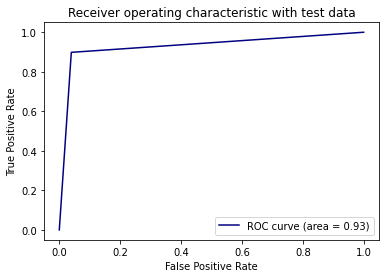

In [47]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,ths = roc_curve(Y_test,Y_pred_tst)
auc_sc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

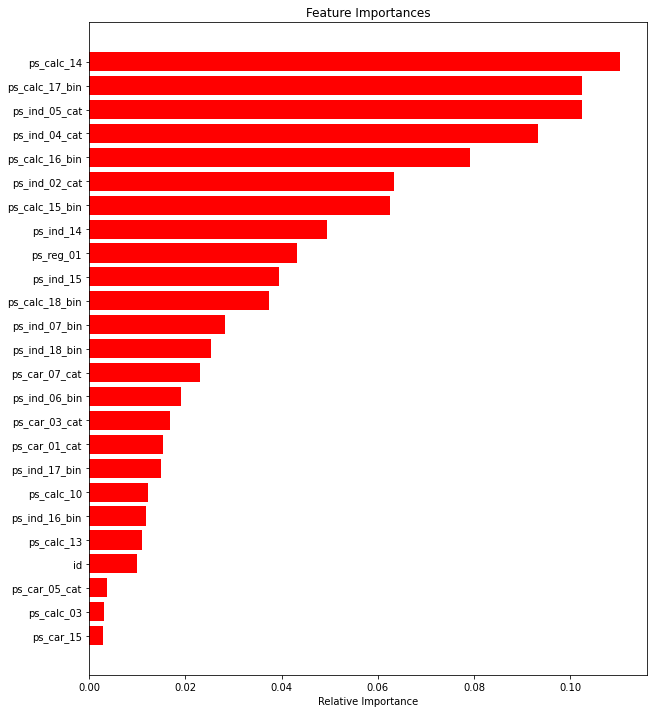

In [48]:
features = train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#**Adaboost Classifier**
---

In [49]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100,random_state=25)
clf.fit(X_train,Y_train)

Y_pred_trn = clf.predict(X_train)
Y_pred_tst = clf.predict(X_test)

print("Train accuracy score:",accuracy_score(Y_train, Y_pred_trn))
print("Test accuracy score:",accuracy_score(Y_test, Y_pred_tst))
print("\n")
print("Train F1score:",f1_score(Y_train, Y_pred_trn))
print("Test F1score:",f1_score(Y_test, Y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(Y_train, Y_pred_trn))
print("Test precision_score:",precision_score(Y_test, Y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(Y_train, Y_pred_trn))
print("Test recall_score:",recall_score(Y_test, Y_pred_tst))

Train accuracy score: 0.9764719472378786
Test accuracy score: 0.9763826893569536


Train F1score: 0.9758881406283156
Test F1score: 0.9758805513016846


Train precision_score: 0.9999908448802282
Test precision_score: 0.9999726302344677


Train recall_score: 0.952919981853713
Test recall_score: 0.952922049694841


Train confusion_matrix


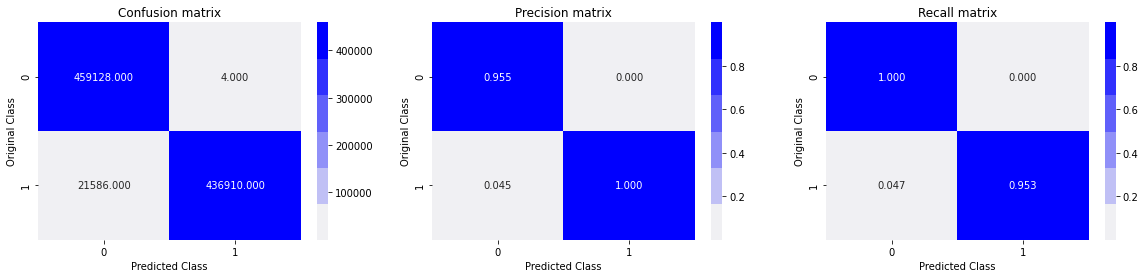

Test confusion_matrix


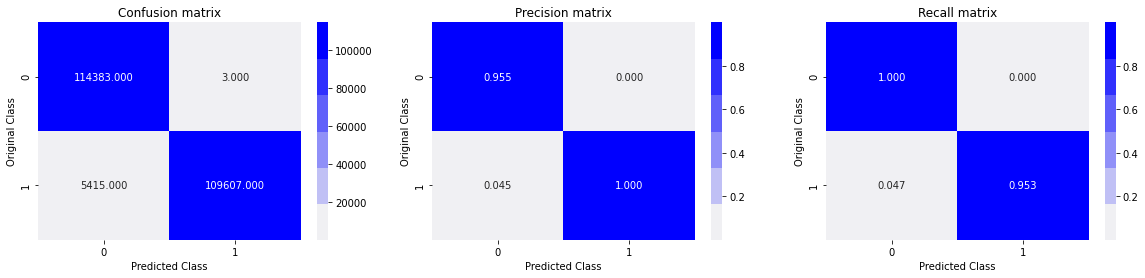

In [50]:
print('Train confusion_matrix')
plot_confusion_matrix(Y_train,clf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(Y_test,clf.predict(X_test))

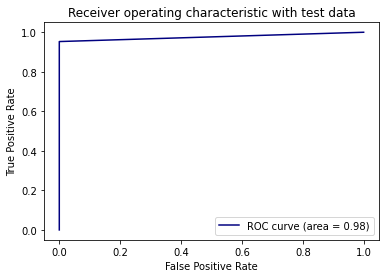

In [51]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,ths = roc_curve(Y_test,Y_pred_tst)
auc_sc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

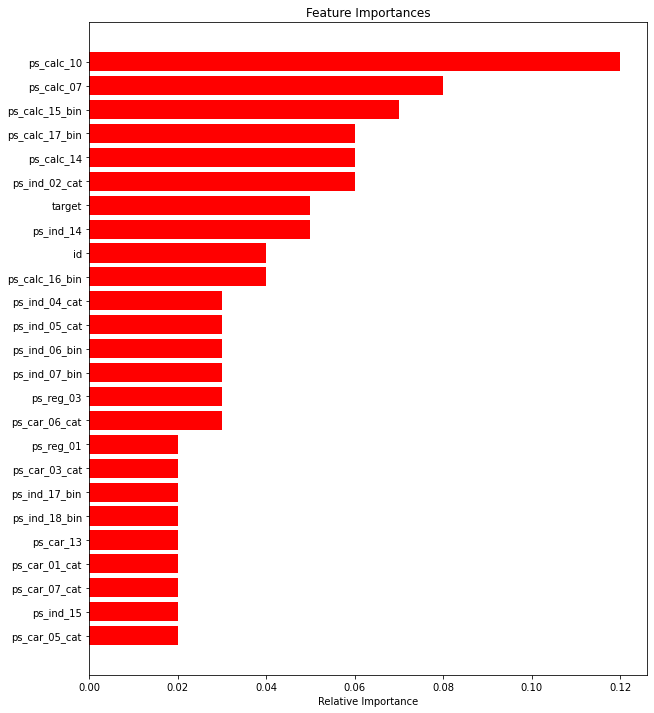

In [52]:
features = train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#**XGBoost Classifier**
---

In [54]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100,random_state=25,learning_rate =0.05)
clf.fit(X_train,Y_train)

Y_pred_trn = clf.predict(X_train)
Y_pred_tst = clf.predict(X_test)

print("Train accuracy score:",accuracy_score(Y_train, Y_pred_trn))
print("Test accuracy score:",accuracy_score(Y_test, Y_pred_tst))
print("\n")
print("Train F1score:",f1_score(Y_train, Y_pred_trn))
print("Test F1score:",f1_score(Y_test, Y_pred_tst))
print("\n")
print("Train precision_score:",precision_score(Y_train, Y_pred_trn))
print("Test precision_score:",precision_score(Y_test, Y_pred_tst))
print("\n")
print("Train recall_score:",recall_score(Y_train, Y_pred_trn))
print("Test recall_score:",recall_score(Y_test, Y_pred_tst))

Train accuracy score: 0.9758594986203559
Test accuracy score: 0.9756983191519041


Train F1score: 0.9752447364892047
Test F1score: 0.9751636083378996


Train precision_score: 1.0
Test precision_score: 1.0


Train recall_score: 0.9516855108877722
Test recall_score: 0.9515310114586775


Train confusion_matrix


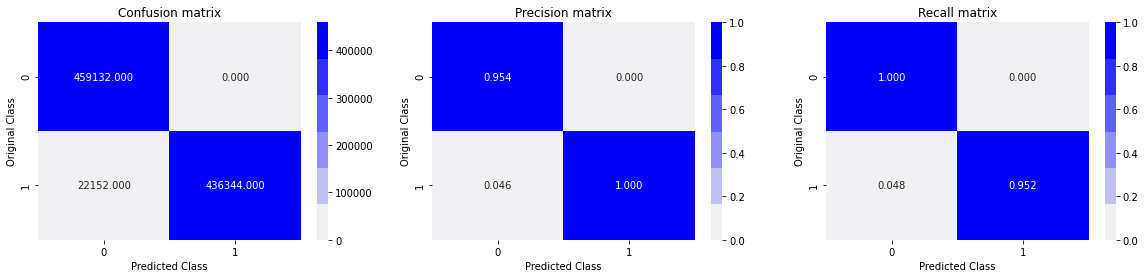

Test confusion_matrix


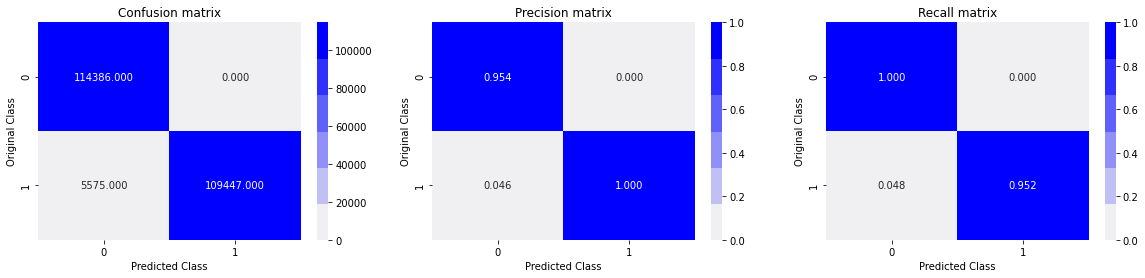

In [55]:
print('Train confusion_matrix')
plot_confusion_matrix(Y_train,clf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(Y_test,clf.predict(X_test))

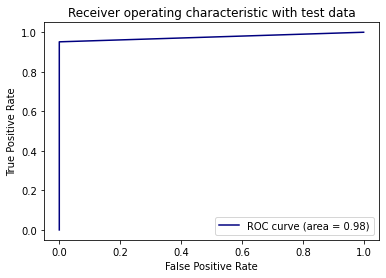

In [56]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,ths = roc_curve(Y_test,Y_pred_tst)
auc_sc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

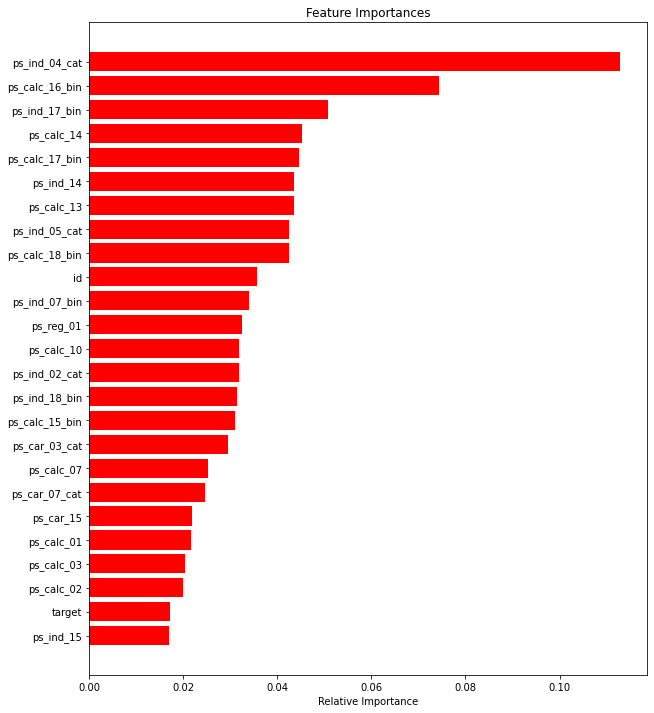

In [58]:
features = train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [59]:
print("Train F1 Score: ",f1_score(Y_train,clf.predict(X_train), average = 'micro'))
print("Test F1 Score: ",f1_score(Y_test,clf.predict(X_test), average = 'micro'))

Train F1 Score:  0.9758594986203559
Test F1 Score:  0.9756983191519041


*   **XGBoost is a better classifier, however, the F1 score is still low because of its error control functionality**
*   **XGBoost performs better given the False Negatives and False Positives, but Adaboost provides a better selection of feature importances**

#**MLP Classification Model**
---

In [60]:
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [61]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [63]:
model = Sequential()
model.add(Dense(300, activation="relu", input_shape = (X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(150,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='softmax'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20 , verbose=1, validation_data=(X_test, Y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               17400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
batch_normalization_3 (Batch (None, 150)               600       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 64,501
Trainable params: 63,601
Non-trainable params: 900
_________________________________________________________________
None
Epoch 1/20
7169/7169 [==============================] - 28s 4ms/step - loss: 0.3413 - binary_accuracy: 0.4993

In [65]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.11899427324533463
Test accuracy: 0.5013861656188965


*   **The model above is underfitting, hence the MLP classification model does NOT perform better than the traditional model**
*   **Changing the architecture would most likely allow us to obtain better results**

#**Inferences**
---

*   **The features of the model are able to obtain an F1 score of 0.97 and AUC score of 0.98, which is much better than the other models**
*   **No need to use One Hot Encoding for categorical variables since after its application, the performance was lower than that of the given training data**

#**Conclusion**
---

In [69]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Train F1-Score","Test F1-Score"]
x.add_row(['Logistic regression (unbalanced)','0','0'])
x.add_row(['LinearSVC (unbalanced)','0','0'])
x.add_row(['Logistic Regression (balanced)','0.57','0.57'])
x.add_row(['LG (Liblinear)','0.57','0.58'])
x.add_row(['Random Forest','0.975','0.975'])
x.add_row(['XGBOOST','0.9752','0.951'])
print(x)

+----------------------------------+----------------+---------------+
|              Model               | Train F1-Score | Test F1-Score |
+----------------------------------+----------------+---------------+
| Logistic regression (unbalanced) |       0        |       0       |
|      LinearSVC (unbalanced)      |       0        |       0       |
|  Logistic Regression (balanced)  |      0.57      |      0.57     |
|          LG (Liblinear)          |      0.57      |      0.58     |
|          Random Forest           |     0.975      |     0.975     |
|             XGBOOST              |     0.9752     |     0.951     |
+----------------------------------+----------------+---------------+
